In [1]:
import sys
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
from matplotlib import cm
from sklearn.metrics import pairwise_distances

sys.path.insert(1, '/Users/andrewroberts/Desktop/git-repos/gp-calibration/python')
from helper_functions import *
from vsem import *

# TODOs
- Set variance to estimate from observed data.
- Implement method to sample from GP prior. 

In [2]:
RANDOM_SEED = 23587693
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
# Setup. 

# Number of time steps (days) to simulate model. 
n_year = 3
n_time_step = 365*n_year

# Parameter to calibrate. 
par_cal_names = ["KEXT"]

In [4]:
# VSEM Defaults.
par_default = get_vsem_default_pars()
print(par_default)
par_default = par_default["value"].values
print(par_default)

   par_name      value
0      KEXT      0.500
1       LAR      1.500
2       LUE      0.002
3     GAMMA      0.400
4      tauV   1440.000
5      tauS  27370.000
6      tauR   1440.000
7        Av      0.500
8        Cv      3.000
9        Cs     15.000
10       Cr      3.000
[5.000e-01 1.500e+00 2.000e-03 4.000e-01 1.440e+03 2.737e+04 1.440e+03
 5.000e-01 3.000e+00 1.500e+01 3.000e+00]


In [6]:
# Choose Calibration parameters and define priors. 
par_prior = get_vsem_default_priors()
par_cal_idx = np.where(par_prior.par_name.isin(par_cal_names))[0]
par_cal_prior = np.take(par_prior, par_cal_idx, axis=0)
dim_par = len(par_cal_names)
par_cal_prior

,par_name,dist,param1,param2
0,KEXT,Uniform,0.2,1.0


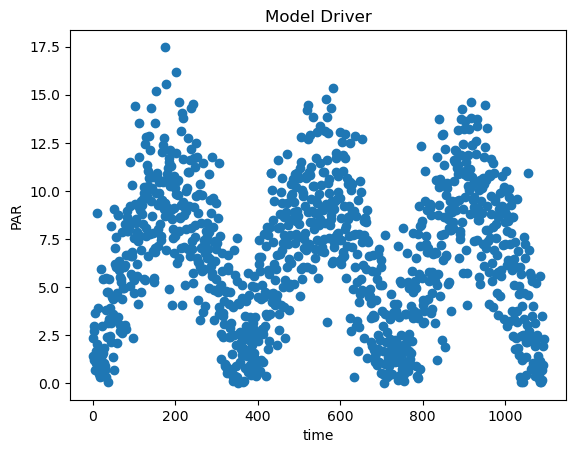

In [7]:
# Forcing/driving data: photosynthetically active radiation. 
# Note that time t here is in days, so t=1 is 1 day and t=365 is 1 year. 
time_steps, model_driver = get_PAR_driver(n_time_step, rng=rng)
plt.plot(time_steps, model_driver, "o")
plt.xlabel("time")
plt.ylabel("PAR")
plt.title("Model Driver")
plt.show()

In [26]:
# Define the forward model, observation operator, and parameter-to-observable map.
# For observation operator, considering a time average of Leaf Area Index (LAI) 
# here so that the output space in the inverse problem is 1d. 

output_names = get_vsem_output_names()
LAI_idx = output_names.index("LAI")

# Forward model. 
fwd = get_vsem_fwd_model(model_driver, dim_par, par_cal_idx, par_default, simplify=False)

# Observation operator.
def obs_op(fwd_model_output):
    lai_trajectory = fwd_model_output[:,:,LAI_idx]
    return lai_trajectory.mean(axis=1)

# Parameter-to-Observable map. 
def param_to_obs_op(par):
    return obs_op(fwd(par))    

In [9]:
# Generate ground truth data and observed data.
signal_to_noise_ratio = 20
par_true = par_default.copy()
par_cal_true = par_true[par_cal_idx]
fwd_true = fwd(par_cal_true)
y_true = obs_op(fwd_true)
sig_eps =  np.mean(y_true) / signal_to_noise_ratio
eps = sp.stats.norm(loc=0, scale=np.sqrt(sig_eps))
y_obs = y_true + eps.rvs(size=y_true.shape, random_state=rng)

In [15]:
# True time average. 
y_true

5.100744091135588

In [16]:
# Observed time average. 
y_obs

5.035171754792247

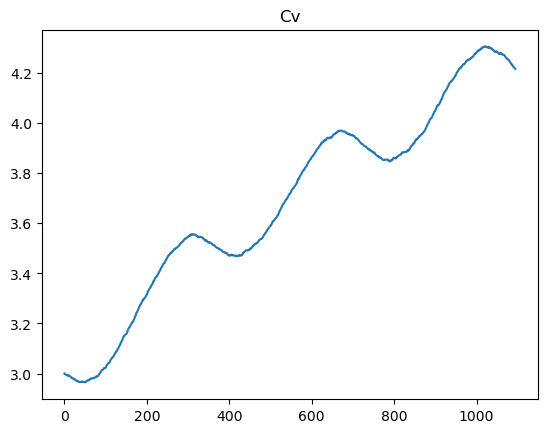

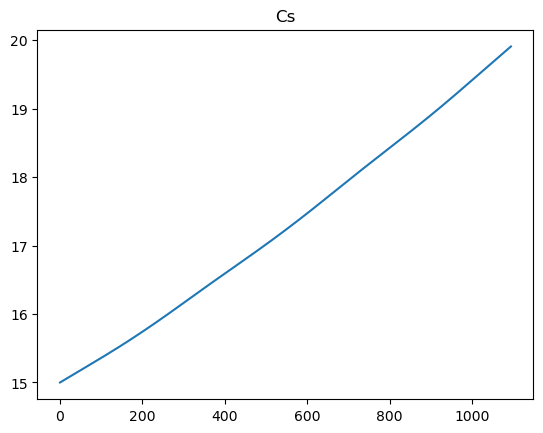

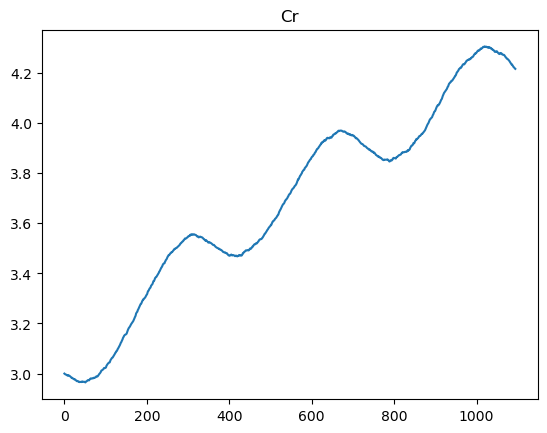

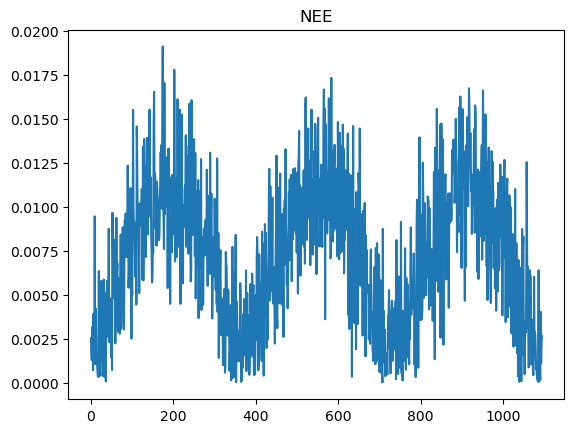

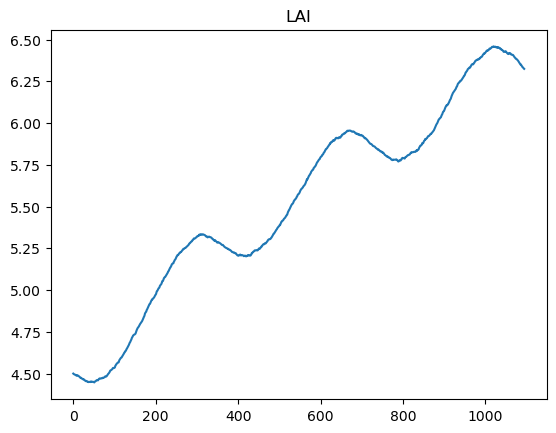

In [17]:
# Plot ground truth and observed data. 
for j in range(fwd_true.shape[2]):
    plt.plot(time_steps, fwd_true[0,:,j])
    plt.title(output_names[j])
    plt.show()

# Log Prior, Exact Likelihood, and Posterior Density Functions

In [18]:
prior = []
for i in range(dim_par):
    loc = par_cal_prior.param1.values[i]
    scale = par_cal_prior.param2.values[i] - loc
    prior.append(sp.stats.uniform(loc=loc, scale=scale))

In [29]:
def calc_llik(par, y, pred_fwd=None, pred_obs=None):
    # The observation `y` is just a scalar. 
    # `param_to_obs_op()` returns array of shape (N_run,).
    # This function returns an array of shape (N_run,) containing the 
    # log-likelihood evaluations at each parameter value. 

    # Compute the observable predicted by the model. 
    if pred_obs is None:
        if pred_fwd is None:
            pred_obs = param_to_obs_op(par)
        else:
            pred_obs = obs_op(pred_fwd)
            
    # Evaluate log-likelihood. 
    return eps.logpdf(y-pred_obs)

def calc_lprior(par):
    # `par` assumed to be either shape (N_par,) for log prior evaluation at single 
    # point or (N_points, N_par) for prior evaluation at `N_points` points. 
    if par.ndim == 1:
        par = par.reshape((1,-1))
    return np.array([prior[i].logpdf(par[:,i]) for i in range(dim_par)]).sum(axis=0)

def calc_lpost(par, pred_fwd=None, pred_obs=None, llik=None, lprior=None, y=None): 

    # Evaluate log-likelihood. 
    if llik is None:
        llik = calc_llik(par, y, pred_fwd, pred_obs)

    # Evaluate log-prior. 
    if lprior is None:
        lprior = calc_lprior(par)

    return lprior+llik

# Design and Test Points

In [32]:
# Generate design points based on prior distribution. 
n_design = 4
lh_sampler = sp.stats.qmc.LatinHypercube(d=dim_par)
uniform_design = lh_sampler.random(n=n_design)
par_cal_design = prior[0].ppf(uniform_design[:,0]).reshape((n_design,1))

In [34]:
# Generate grid of test points. 
n_grid_1d = 100
grid_bounds = np.asarray(par_cal_prior[["param1", "param2"]]).T
par_cal_test = np.linspace(grid_bounds[0,0], grid_bounds[1,0], num=n_grid_1d).reshape((n_grid_1d,1))
n_test = par_cal_test.shape[0]

In [36]:
# Generate llik responses at design and test points.
fwd_design = fwd(par_cal_design)

pred_obs_design = obs_op(fwd_design)
pred_obs_test = param_to_obs_op(par_cal_test)

llik_design = calc_llik(par_cal_design, y_obs, pred_obs=pred_obs_design)
llik_test = calc_llik(par_cal_test, y_obs, pred_obs=pred_obs_test)

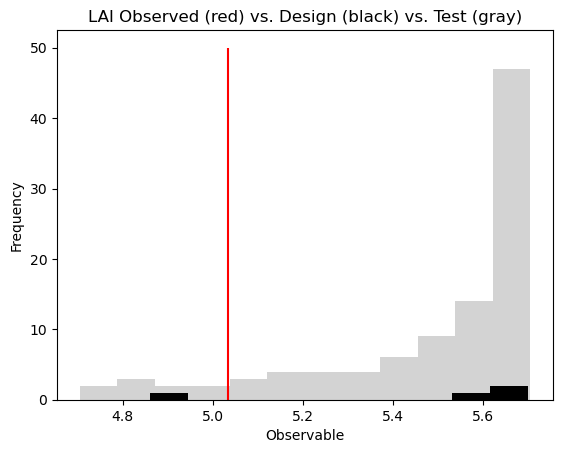

In [39]:
# Plot simulated observables vs. ground truth.
plt.hist(pred_obs_test, bins=12, color="lightgray")
plt.hist(pred_obs_design, color="black")
plt.vlines(y_obs, ymin=0, ymax=50, color="red")
plt.xlabel("Observable")
plt.ylabel("Frequency")
plt.title("LAI Observed (red) vs. Design (black) vs. Test (gray)")
plt.show()

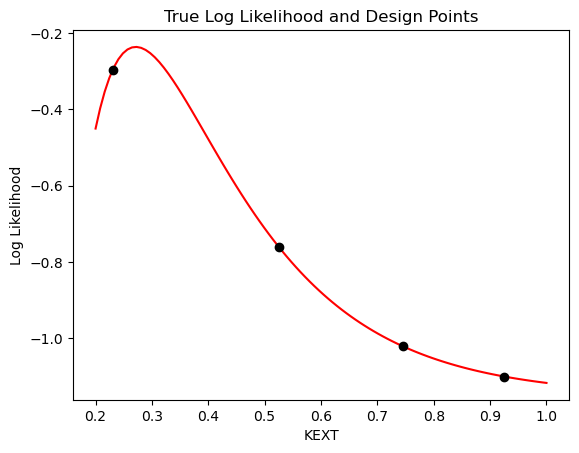

In [41]:
# Log-Likelihood Plot.
plt.plot(par_cal_test, llik_test, color="red")
plt.plot(par_cal_design, llik_design, "ok")
plt.xlabel(par_cal_names[0])
plt.ylabel("Log Likelihood")
plt.title("True Log Likelihood and Design Points")

plt.show()

## Log Likelihood Gaussian Process Emulators: Specifying the Models

### Calculations for Data-Informed GP Hyperparameterization

In [44]:
# Statistics of log-likelihood design. 
llik_max_idx = np.argmax(llik_design)
llik_max = llik_design[llik_max_idx]
llik_rng = llik_max - np.min(llik_design)
llik_std = np.std(llik_design)
llik_mean = np.mean(llik_design)

# Statistics of parameter design. 
par_cal_max = par_cal_design[llik_max_idx,:]
pairwise_dist_ranges = get_pairwise_dist_range_per_dim(par_cal_design)

# Quantities based on prior. 
prior_sd = np.sqrt([p.var() for p in prior])

### Constant Mean, Gaussian Kernel
MAP estimates with empirically determined priors on the hyperparameters. 

In [46]:
# Inverse Gamma prior for lengthscale parameter; constrained so that the majority of the 
# mass lies between the minimum and maximum pairwise distances in the design data.
dist_min = pairwise_dist_ranges[0,0]
dist_max = pairwise_dist_ranges[1,0]
midpoint = 0.5*(dist_min + dist_max)
alpha_guess,beta_guess = get_IG_pars_from_mean_sd(midpoint, dist_max-midpoint)
lengthscale_param = pm.find_constrained_prior(
    pm.InverseGamma, lower=dist_min, upper=dist_max, mass=0.9, 
    init_guess={"alpha":alpha_guess, "beta":beta_guess}
)

lengthscale_param

{'alpha': 6.237778157113525, 'beta': 1.9857916646957787}

In [47]:
# Half-Normal prior for the scale parameter.
upper_bound=0.5*llik_rng
scale_params = pm.find_constrained_prior(
    pm.HalfNormal, lower=0, upper=upper_bound, mass=0.9, 
    init_guess={"sigma":0.5*upper_bound}
)

scale_params

{'sigma': 0.24481462383029753}

In [49]:
with pm.Model() as gpModel1:

    # Design data. 
    X_design = pm.Data("X", par_cal_design)
    Y_design = pm.Data("Y", llik_design)

    # Mean function.
    mean_cst = pm.Normal("beta0", mu=llik_mean, sigma=llik_std, shape=1)
    mean_func = pm.gp.mean.Constant(c=mean_cst)

    # Covariance function. 
    scale = pm.HalfNormal("alpha", **scale_params)
    lengthscale = pm.InverseGamma("ell", shape=1, **lengthscale_param)
    cov_func = np.power(scale,2) * pm.gp.cov.ExpQuad(1, ls=lengthscale)

    # Specify the GP.
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)

    # Noiseless GP.  
    y_ = gp.marginal_likelihood("Y_process", X=X_design, y=Y_design, sigma=0)

### Constant Mean, Quadratic+Gaussian Kernel 

In [59]:
mean_shift_param = pm.find_constrained_prior(
    pm.HalfNormal, lower=0.0, upper=0.2*llik_rng, mass=0.9, init_guess={"sigma": 0.1*llik_rng}
)

quad_offset_param = pm.find_constrained_prior(
    pm.HalfNormal, lower=0.0, upper=0.1*llik_rng, mass=0.9, init_guess={"sigma": 0.05*llik_rng}
)

upper_bound_Gauss=0.2*llik_rng
scale_param_Gauss = pm.find_constrained_prior(
    pm.HalfNormal, lower=0, upper=upper_bound_Gauss, mass=0.9, 
    init_guess={"sigma":0.5*upper_bound_Gauss}
)

print(mean_shift_param)
print(quad_offset_param)
print(upper_bound_Gauss)

{'sigma': 0.097925849532119}
{'sigma': 0.0489629247660595}
0.16107368208980713


In [61]:
with pm.Model() as gpModel2:

    # Design data. 
    X_design = pm.Data("X", par_cal_design)
    Y_design = pm.Data("Y", llik_design)

    # Mean function.
    mean_shift = pm.HalfNormal("mean_shift", **mean_shift_param, shape=1)
    mean_func = pm.gp.mean.Constant(c=llik_max + mean_shift)

    # Covariance function: Quadratic part. 
    quad_shift = pm.MvNormal("s", mu=par_cal_max, cov=np.power(prior_sd,2) * np.eye(dim_par))
    quad_offset = pm.HalfNormal("c", **quad_offset_param, shape=1)
    scaleQ = pm.HalfNormal("alphaQ", sigma=2*scale_param_Gauss["sigma"])
    corr_func_Q = pm.gp.cov.Polynomial(1, c=quad_shift, d=2, offset=quad_offset)
    
    # Covariance function: Gaussian part. 
    scaleG = pm.HalfNormal("alphaG", **scale_param_Gauss)
    lengthscale = pm.InverseGamma("ell", shape=1, **lengthscale_param)
    corr_func_G = pm.gp.cov.ExpQuad(1, ls=lengthscale)

    # Covariance function. 
    cov_func = np.power(scaleQ,2) * corr_func_Q + np.power(scaleG,2) * corr_func_G
    
    # Specify the GP.
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)

    # Noiseless GP.  
    y_ = gp.marginal_likelihood("Y_process", X=X_design, y=Y_design, sigma=0)

## Fitting Emulators

In [50]:
# Note on variable transformations during optimization: 
# https://stackoverflow.com/questions/42146962/what-does-the-find-map-output-mean-in-pymc3

with gpModel1:
    hyperpar_estimates1 = pm.find_MAP()

print(hyperpar_estimates1)

/Users/andrewroberts/opt/miniconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

{'beta0': array([-0.72346011]), 'alpha_log__': array(-1.21393207), 'ell_log__': array([-1.03931647]), 'alpha': array(0.29702705), 'ell': array([0.35369636])}


In [62]:
with gpModel2:
    hyperpar_estimates2 = pm.find_MAP()

print(hyperpar_estimates2)

/Users/andrewroberts/opt/miniconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

{'mean_shift_log__': array([-20.15776069]), 's': array([-0.12279638]), 'c_log__': array([-4.67183459]), 'alphaQ_log__': array(-1.16990704), 'alphaG_log__': array(-1.90079202), 'ell_log__': array([-1.27733115]), 'mean_shift': array([1.76033679e-09]), 'c': array([0.00935509]), 'alphaQ': array(0.31039579), 'alphaG': array(0.14945021), 'ell': array([0.27878033])}


In [75]:
hyperpar_estimates2["alphaQ"] = 0.31039579

## GP Predictions

In [51]:
with gpModel1: 
    pred1 = gp.predict(Xnew=par_cal_test, point=hyperpar_estimates1, diag=True)

In [72]:
with gpModel2: 
    pred2 = gp.predict(Xnew=par_cal_test, point=hyperpar_estimates2, diag=True)

### Summarize Predictions

In [52]:
# Negatively oriented so that smaller scores are better. 
def calc_crps_Gaussian(y, m, v):
    s = np.sqrt(v)
    y_norm = (y-m)/s
    F = sp.stats.norm.cdf(y_norm)
    f = sp.stats.norm.pdf(y_norm)
    crps = s * (y*(2*F - 1) + 2*f - np.power(np.pi, -0.5))
    return -crps

# Negatively oriented so that smaller scores are better. 
def calc_log_score_Gaussian(y, m, v):
    return -sp.stats.norm.logpdf(y, loc=m, scale=np.sqrt(v))

In [73]:
# Collect mean and variance predictions. 
pred_mean = []
pred_var = []
pred_sd = []

pred_list = [pred1, pred2]
n_models=len(pred_list)
for i in range(len(pred_list)):
    pred_list[i] = {"mean":pred_list[i][0], "var":pred_list[i][1]} 

In [54]:
# Model evaluation. 
def calc_gp_pointwise_errors(y_pred, y_true):
    m = y_pred["mean"]
    v = y_pred["var"]
    mae = np.abs(m - y_true)
    crps = calc_crps_Gaussian(y_true, m, v)
    log_score = calc_log_score_Gaussian(y_true, m, v)
    return {"mae":mae, "crps":crps, "log_score":log_score}

# Note that this will return NaN if there are non-positive numbers in `x`. 
# TODO: generalize this to allow for mix of negative and positive numbers. 
def weighted_mean(x, log_weights=None, return_log=False):
    if log_weights is None:
        log_weights = 0.0
    
    # LogSumExp for numerically stable weighted average. 
    log_summands = np.log(x) + log_weights
    log_weighted_mean = sp.special.logsumexp(log_summands) - np.log(len(log_summands))
    if return_log:
        return log_weighted_mean
    return np.exp(log_weighted_mean)

def average_pointwise_errors(y_pred, metrics=["mae", "log_score"], log_weights=None, return_log=False):
    mean_metrics = {}
    for metric in metrics:
        mean_metrics[metric] = weighted_mean(y_pred[metric], log_weights=log_weights, return_log=return_log)

    return mean_metrics

In [55]:
for pred in pred_list:
    pred.update(calc_gp_pointwise_errors(pred, llik_test))

In [56]:
def plot_gp_fit_1d(x_grid, y_grid, gp_mean, gp_var, x_points=None, y_points=None):
    fig,ax = plt.subplots()
    gp_sd = np.sqrt(gp_var)
    ax.plot(x_grid, y_grid, color="red")
    ax.plot(x_grid, gp_mean, color="blue")
    ax.plot(x_grid, gp_mean+2*gp_sd, color="gray")
    ax.plot(x_grid, gp_mean-2*gp_sd, color="gray")

    if (x_points is not None) and (y_points is not None):
        ax.plot(x_points, y_points, "ok")

    return fig

In [90]:
X_test = np.array([[1,2,3], [4,5,3]])
print(X_test)

[[1 2 3]
 [4 5 3]]


In [94]:
X_test * np.array([1,2,3])

array([[ 1,  4,  9],
       [ 4, 10,  9]])

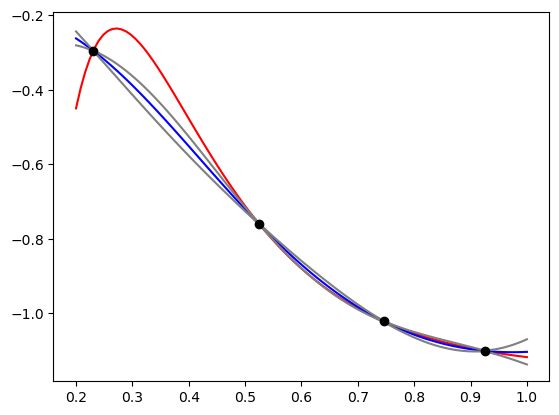

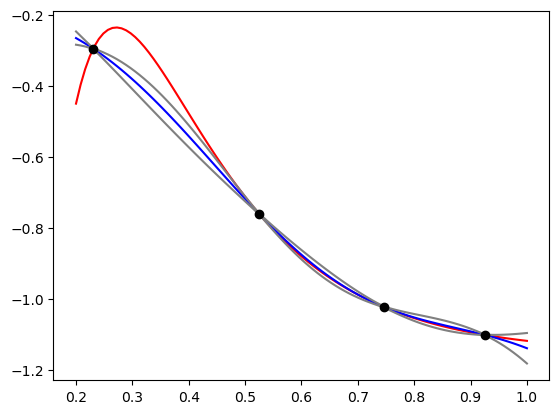

In [74]:
# GP predictive plots. 

for pred in pred_list:
    fig = plot_gp_fit_1d(par_cal_test, llik_test, pred["mean"], pred["var"], 
                         par_cal_design, llik_design)
    fig